In [2]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

def radius_to_capacitance(np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*np_radius

    return cap

def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))
def stretched_exp_saturation(t, tau, a0, beta):
    return a0*(1 - np.exp(-(t/tau)**beta))
def streched_moments(tau, beta, n=1):
    return gamma(n/np.array(beta))*(np.array(tau)**n)/np.array(beta)

### 2 Electrode Setup

In [29]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs/"
folder                  = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_increasing_steps/"
U_0                     = 0.1
step_vals               = [234,350,469,705,938,1405,1875,2810,3750,5625,7500,11250,15000,22500,30000,45000,60000,90000,120000]
# step_vals               = [2810,3750,5625,7500,11250,15000,22500,30000,45000,60000,90000,120000]
data                    = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=2_{steps}.csv") for steps in step_vals}
pot                     = {steps : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Nz=1_Ne=2_{steps}.csv") for steps in step_vals}
t_vals                  = {steps : np.arange(len(data[steps]))*1e-10*1e9 for steps in step_vals}
step_idx                = [[steps*i for i in range(12)] for steps in step_vals]

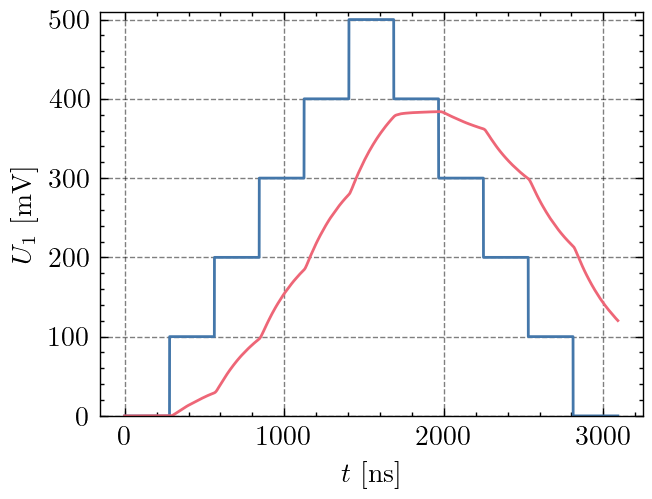

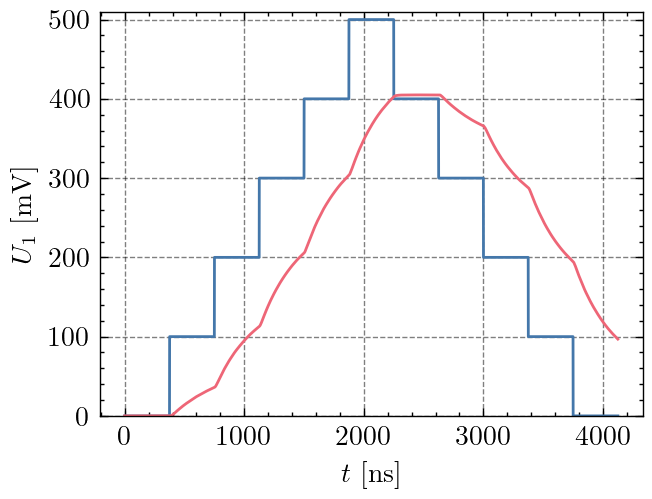

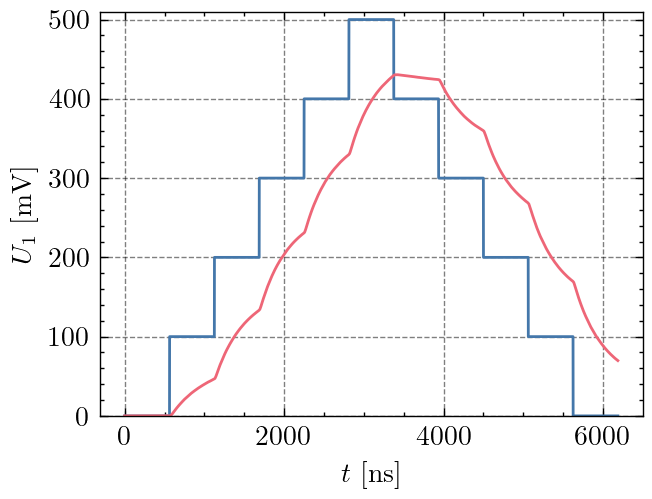

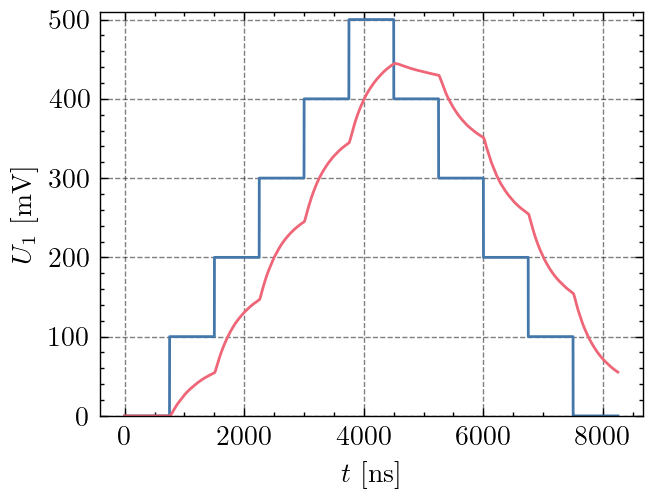

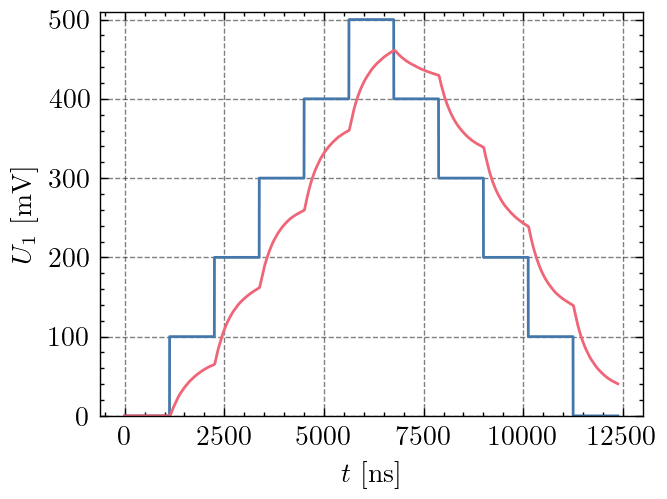

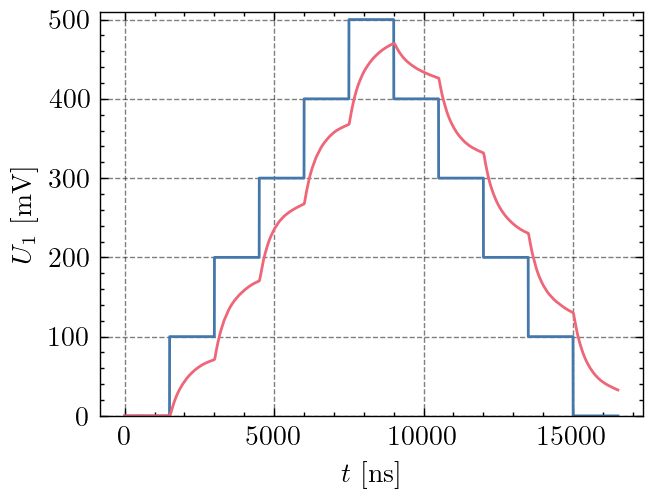

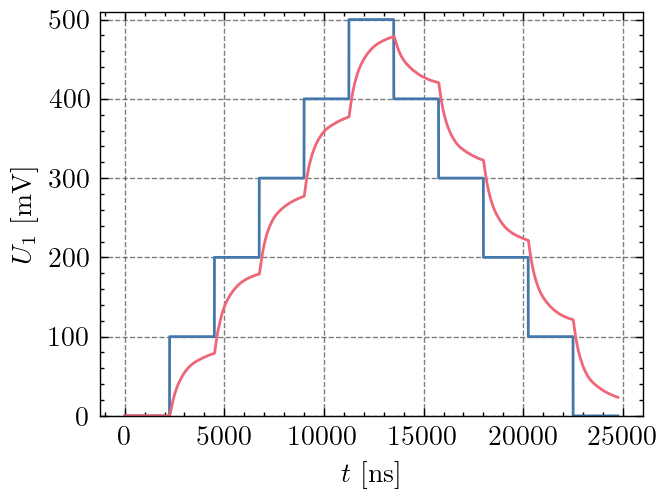

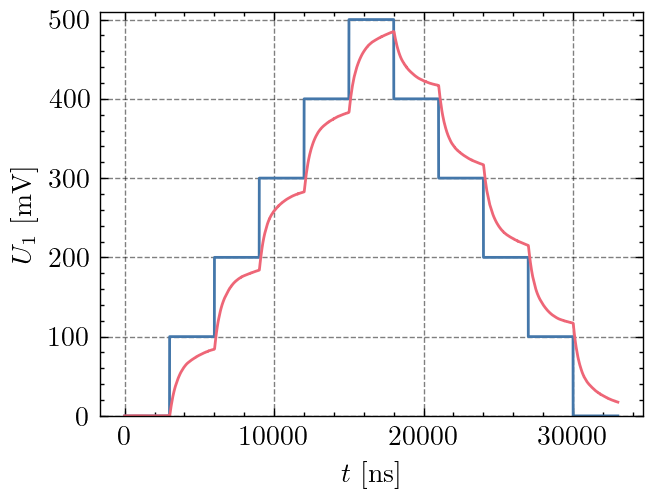

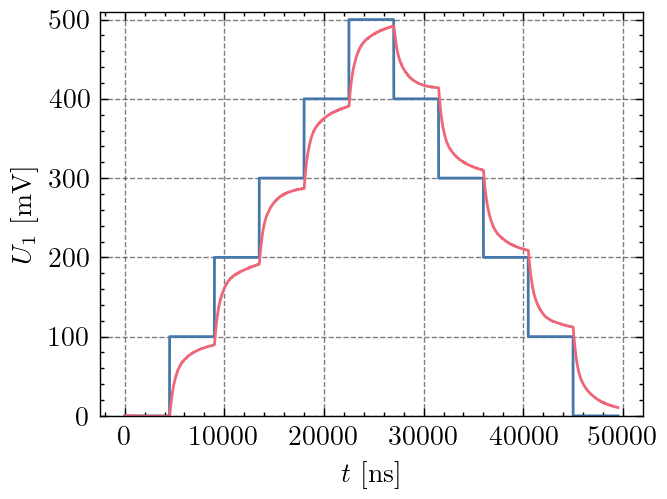

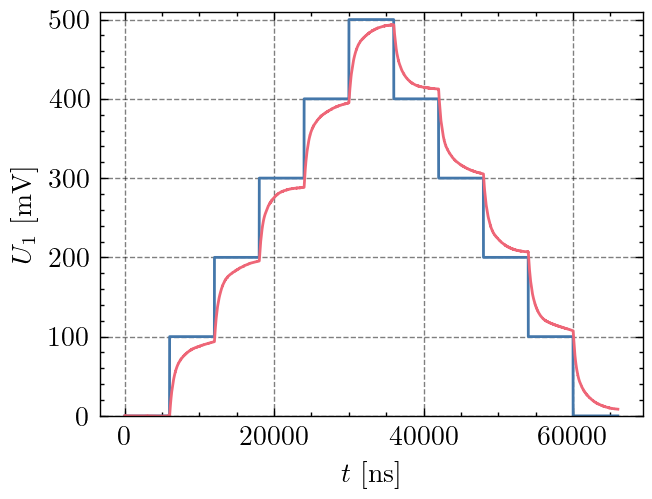

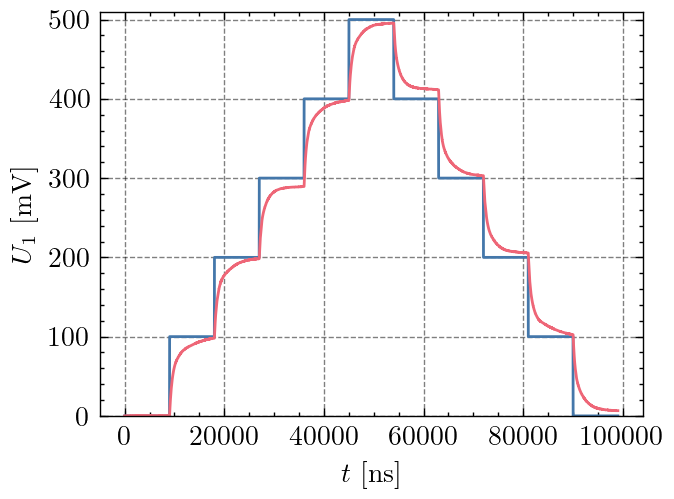

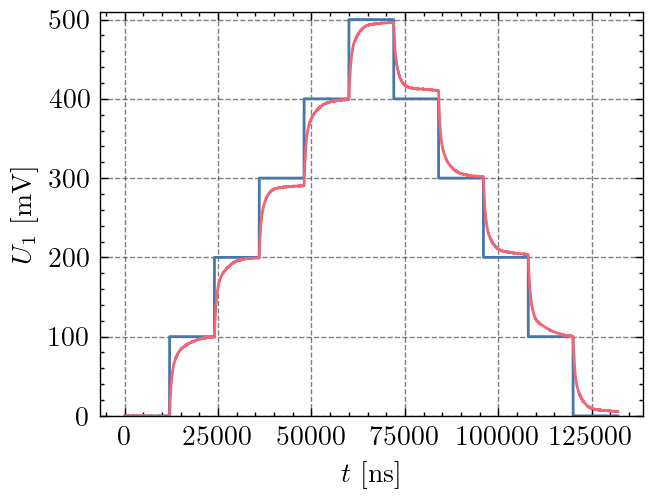

In [4]:
for steps in step_vals:

    fig     = plt.figure(dpi=200)
    ax      = fig.add_subplot()
    t       = t_vals[steps]
    x       = data[steps]['E0']*1000
    y       = data[steps]['Current'].values*1000
    y_e     = data[steps]['Error'].values*1000

    ax.plot(t, x)
    ax.plot(t, y)
    ax.set_ylim(0, 510)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U_1$ [mV]")
    
    fig.savefig(f"../plots/dc_input/2_electrodes/increasing_steps/response_{steps}.svg", transparent=True)

/tmp/ipykernel_18234/1439474163.py:6: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-(t_shift/tau)**beta))
/tmp/ipykernel_18234/1439474163.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


,0,1,2,3,4
23.4,2.710790e+03,43600.787182,1.354380e+05,117256.634694,554871.825580
35.0,4.932677e+04,155171.351044,3.818669e+05,374111.262821,371766.703905
46.9,1.591284e+05,397413.051080,1.583753e+06,588193.495157,107.778695
70.5,6.511080e+05,642333.753778,9.664911e+01,114.950872,114.338832
93.8,1.105177e+06,112.467213,1.309764e+02,133.237531,145.189014
140.5,1.661331e+02,173.200854,1.899148e+02,184.815009,191.692915
187.5,2.830141e+02,217.052891,2.174313e+02,223.241049,219.809930
281.0,4.066220e+02,273.227922,2.827439e+02,272.064919,273.136749
375.0,3.903381e+02,333.761848,3.251306e+02,324.342274,309.102140
562.5,4.946208e+02,400.890474,3.751468e+02,374.637920,373.434484


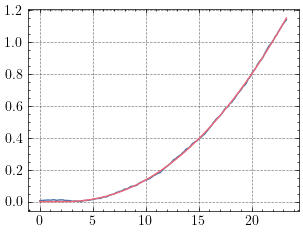

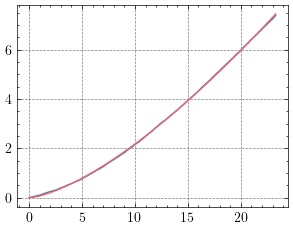

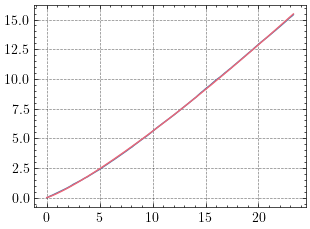

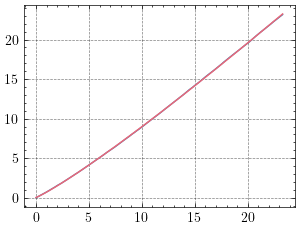

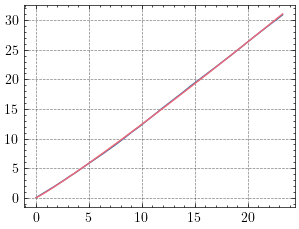

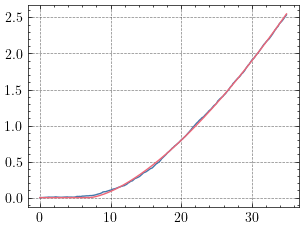

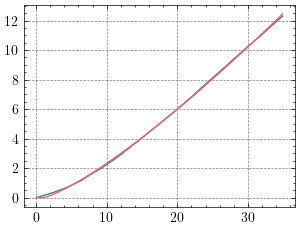

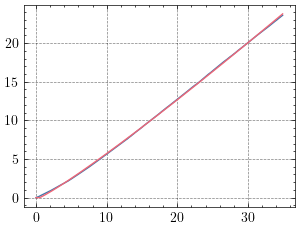

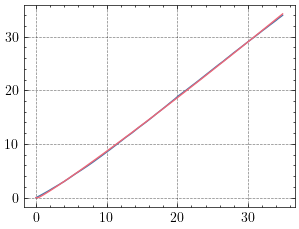

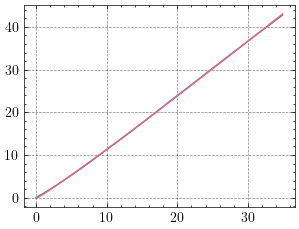

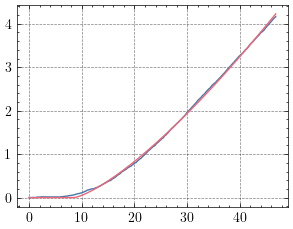

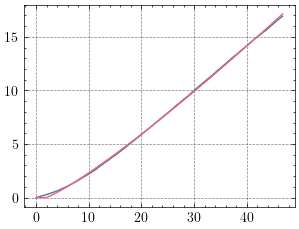

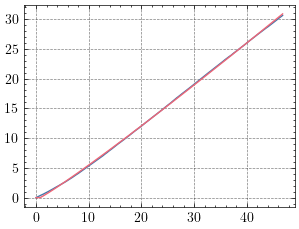

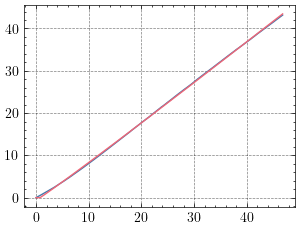

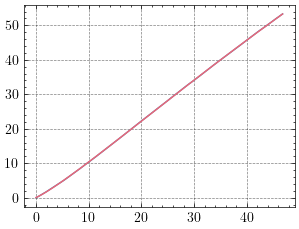

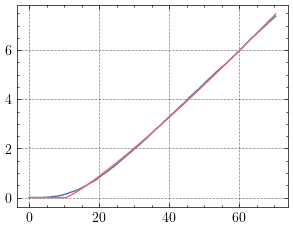

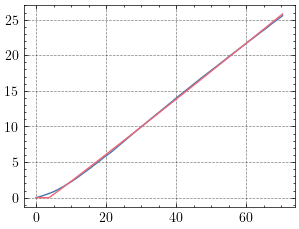

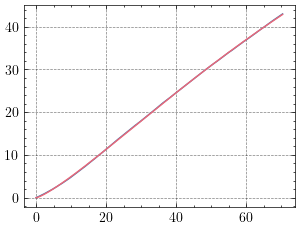

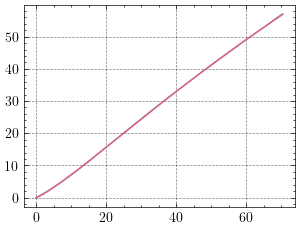

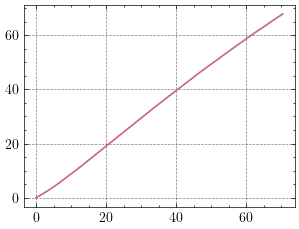

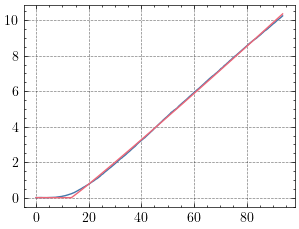

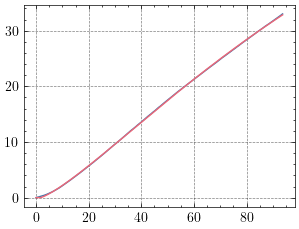

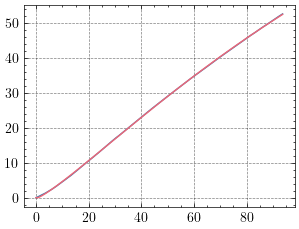

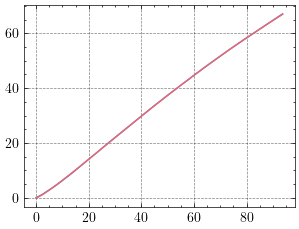

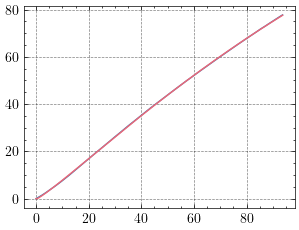

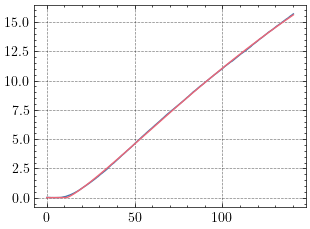

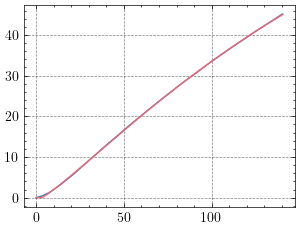

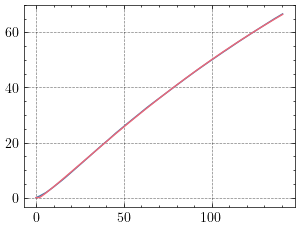

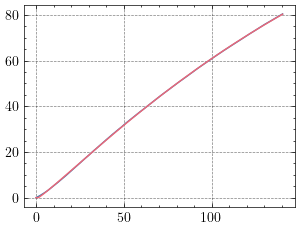

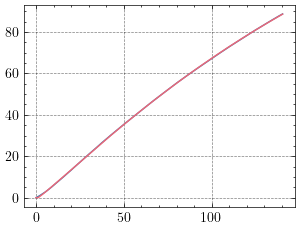

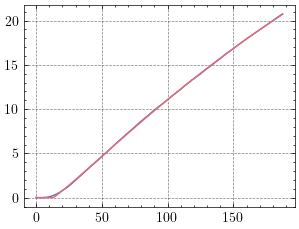

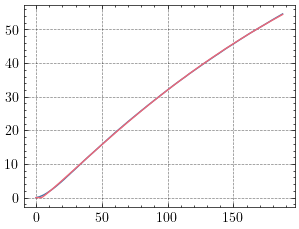

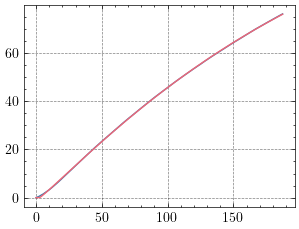

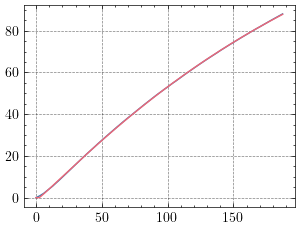

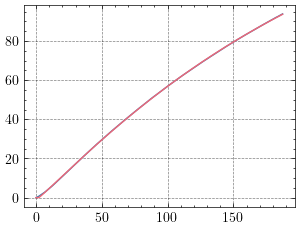

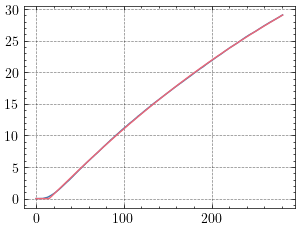

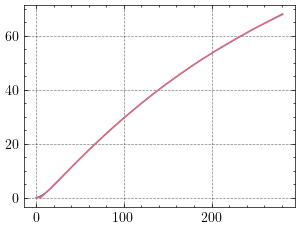

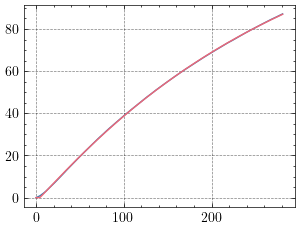

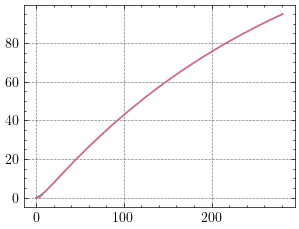

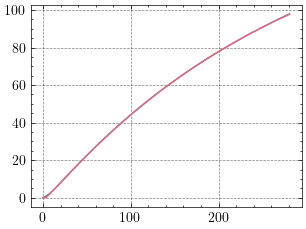

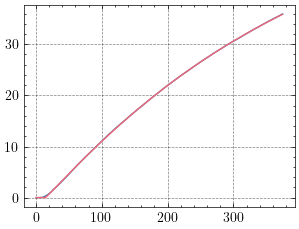

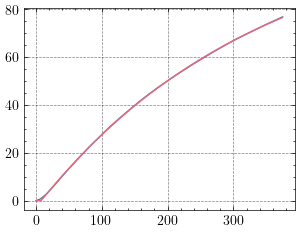

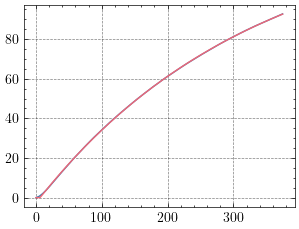

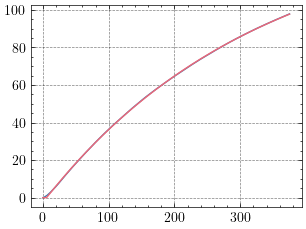

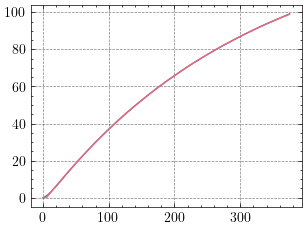

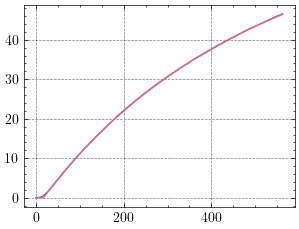

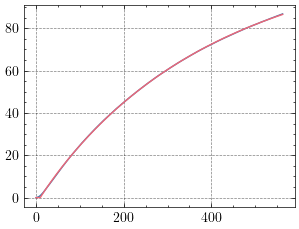

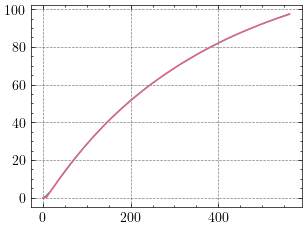

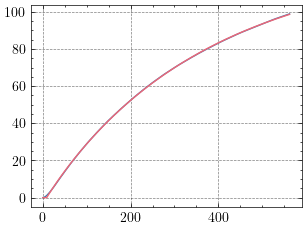

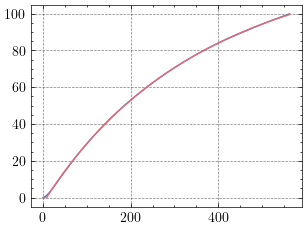

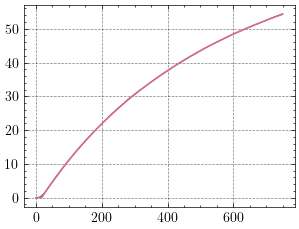

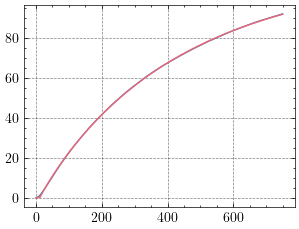

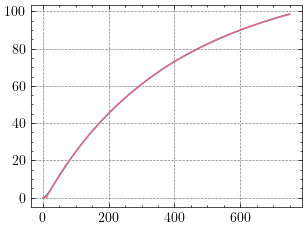

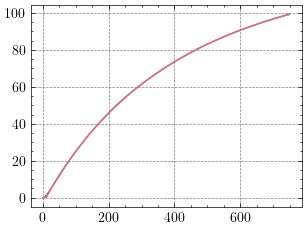

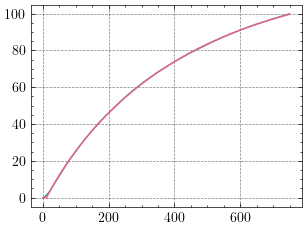

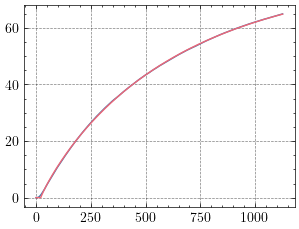

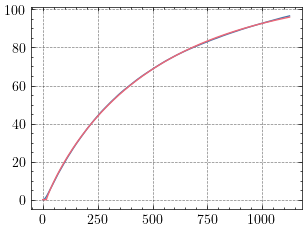

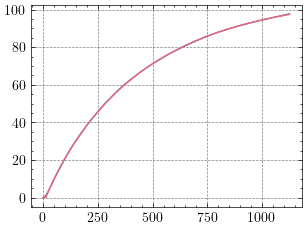

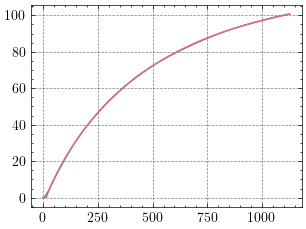

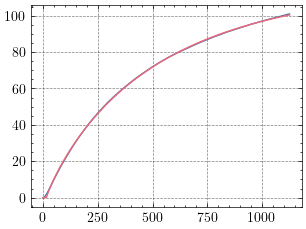

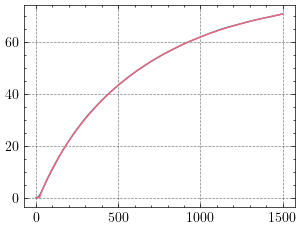

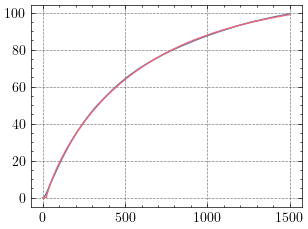

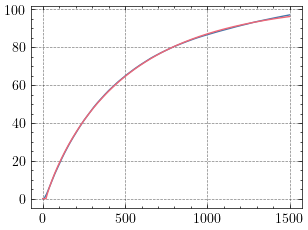

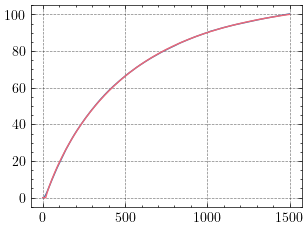

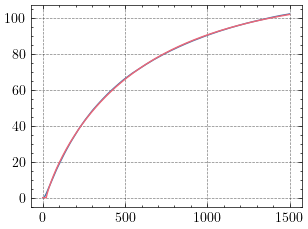

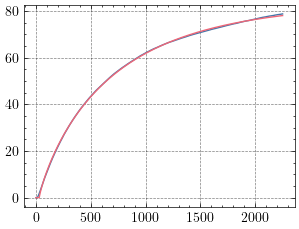

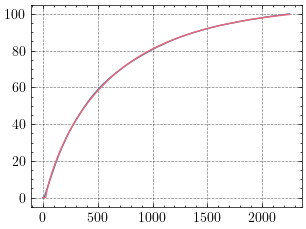

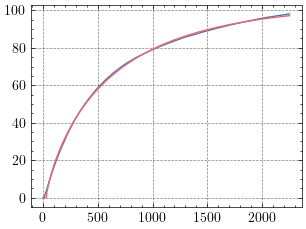

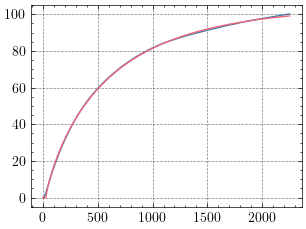

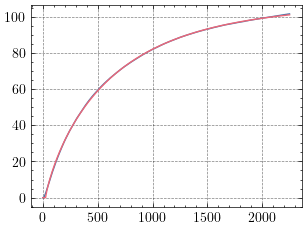

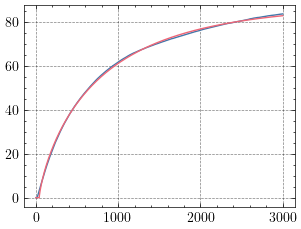

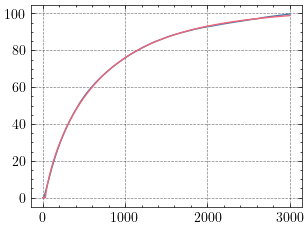

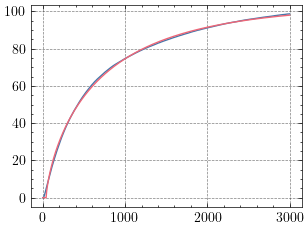

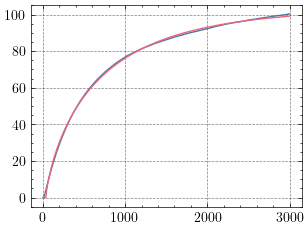

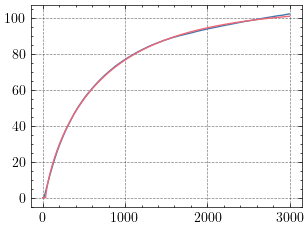

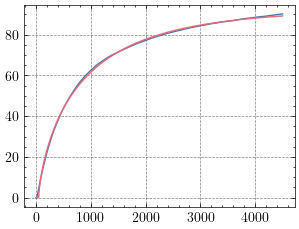

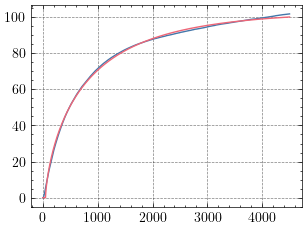

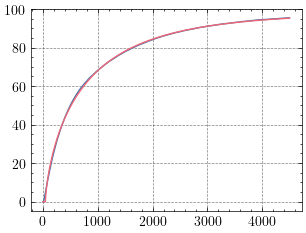

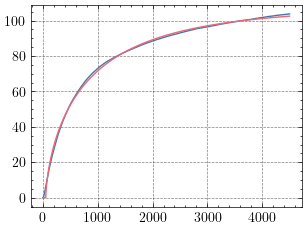

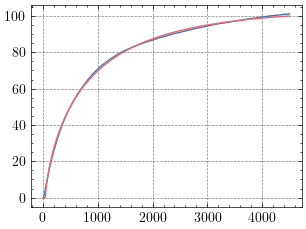

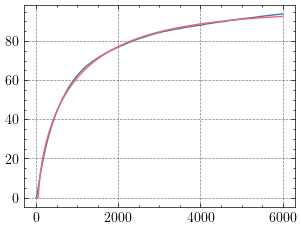

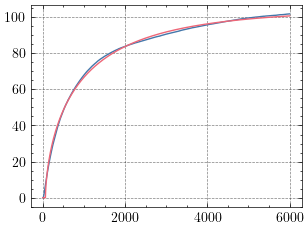

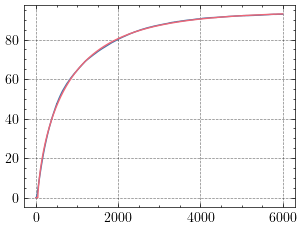

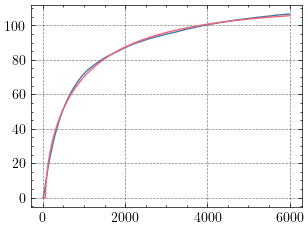

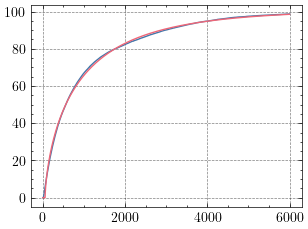

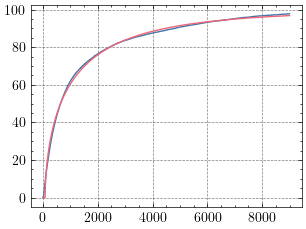

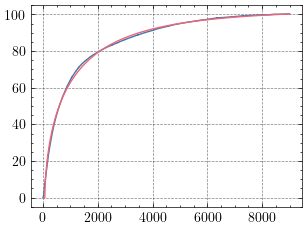

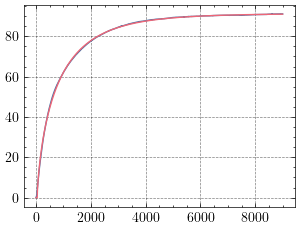

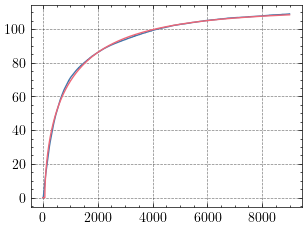

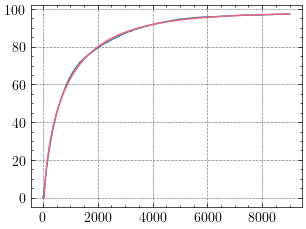

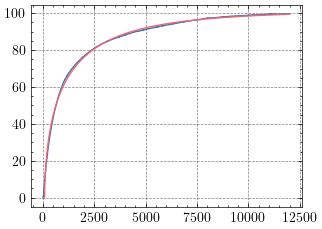

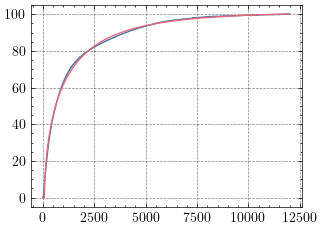

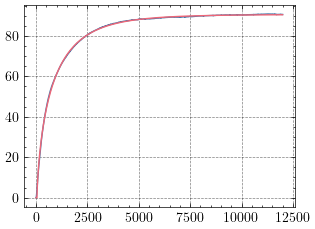

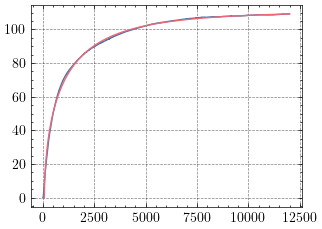

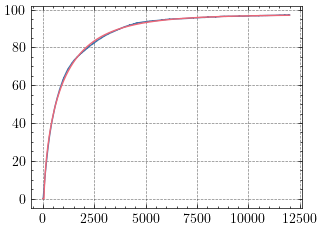

In [30]:
def exp_saturation(t, tau, a0, t0):
    t_shift = np.clip(t - t0, 0, None)
    return a0*(1 - np.exp(-t_shift/tau))
def stretched_exp_saturation(t, tau, a0, beta, t0):
    t_shift = np.clip(t - t0, 0, None)
    return a0*(1 - np.exp(-(t_shift/tau)**beta))

tau_val = []
p_val   = []
for i, (key, df) in enumerate(data.items()):
    t_v     = t_vals[key].copy()
    y_v     = df['Current'].values.copy()*1000
    steps_v = step_idx[i]
    taus    = []
    ps      = []
    for j in range(1,6):
        r1  = steps_v[j]
        r2  = steps_v[j+1]
        t   = t_v[:r2-r1]
        y   = y_v[r1:r2]
        y   = y - np.min(y)
        plt.figure()
        plt.plot(t,y)
        p,_ = curve_fit(exp_saturation, t, y, maxfev=10000)
        p,_ = curve_fit(stretched_exp_saturation, t, y, maxfev=10000, p0=[p[0],p[1],1,p[2]])
        plt.plot(t, stretched_exp_saturation(t, *p))
        # taus.append(p[0])
        taus.append((p[0]/p[2])*gamma(1/p[2]))
        ps.append(p)
    tau_val.append(taus)
    p_val.append(ps)
tau_df  = pd.DataFrame(tau_val, index=np.array(step_vals)/10)
tau_df

In [31]:
tau_df

,0,1,2,3,4
23.4,2.710790e+03,43600.787182,1.354380e+05,117256.634694,554871.825580
35.0,4.932677e+04,155171.351044,3.818669e+05,374111.262821,371766.703905
46.9,1.591284e+05,397413.051080,1.583753e+06,588193.495157,107.778695
70.5,6.511080e+05,642333.753778,9.664911e+01,114.950872,114.338832
93.8,1.105177e+06,112.467213,1.309764e+02,133.237531,145.189014
140.5,1.661331e+02,173.200854,1.899148e+02,184.815009,191.692915
187.5,2.830141e+02,217.052891,2.174313e+02,223.241049,219.809930
281.0,4.066220e+02,273.227922,2.827439e+02,272.064919,273.136749
375.0,3.903381e+02,333.761848,3.251306e+02,324.342274,309.102140
562.5,4.946208e+02,400.890474,3.751468e+02,374.637920,373.434484


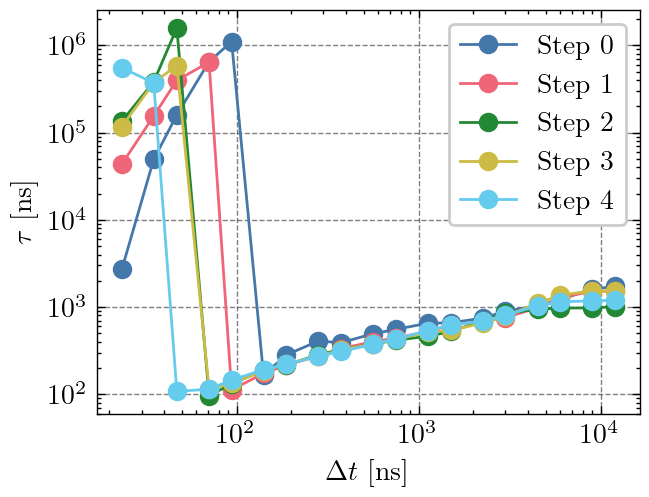

In [33]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i in tau_df.columns:
    ax.plot(tau_df.index,tau_df.iloc[:,i], 'o-', label=f'Step {i}')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$\Delta t$ [ns]')
ax.set_ylabel('$\\tau$ [ns]')
ax.legend()
fig.savefig(f"../plots/dc_input/2_electrodes/tau_vs_step_size.svg", transparent=True)

Text(0, 0.5, '$\\overline{\\tau}$ [ns]')

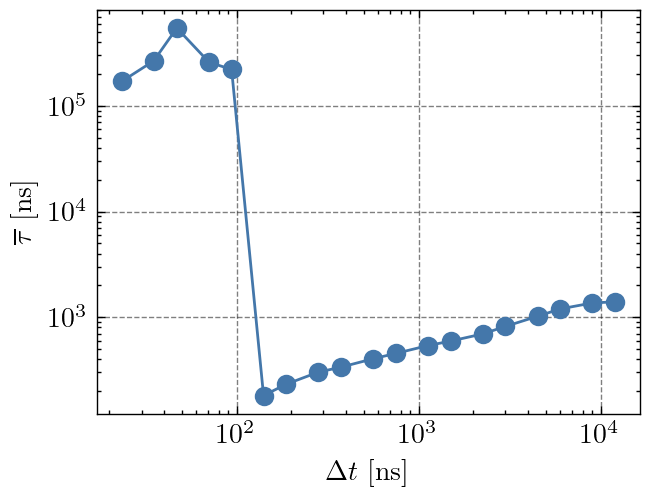

In [45]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(tau_df.index, tau_df.mean(axis=1), 'o-')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$\Delta t$ [ns]')
ax.set_ylabel('$\overline{\\tau}$ [ns]')

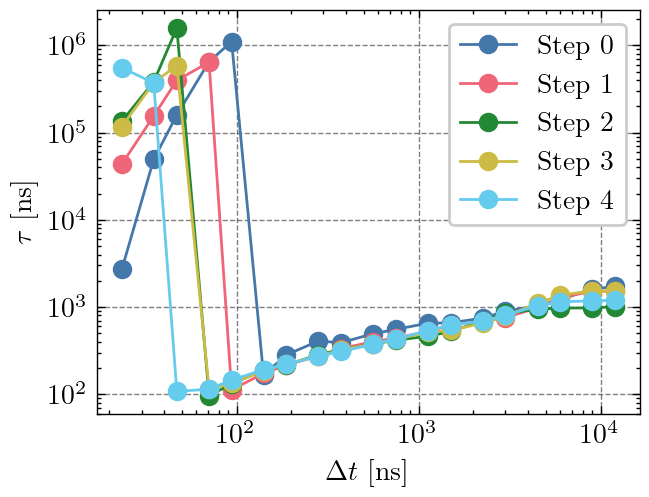

In [66]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i in tau_df.columns:
    ax.plot(tau_df.index,tau_df.iloc[:,i], 'o-', label=f'Step {i}')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$\Delta t$ [ns]')
ax.set_ylabel('$\\tau$ [ns]')
ax.legend()
fig.savefig(f"../plots/dc_input/2_electrodes/tau_vs_step_size.svg", transparent=True)

---

In [41]:
N_voltages      = 200000
steps_between_s = [0,400,800,1600,2000,4000,5000,10000,20000,40000]
steps_per_step  = 40000
time_step       = 1e-9
cap             = 5e3
U_0             = 0.1
t_vals          = np.arange(N_voltages-1)*time_step*1e6
# folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/two_step_input/"
folder          = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_two_step_input/"
data_two        = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{steps}.csv") for steps in steps_between_s}

[ 0.59337746 17.07230653]
[ 0.50047496 17.06951707]


(0.0, 10.0)

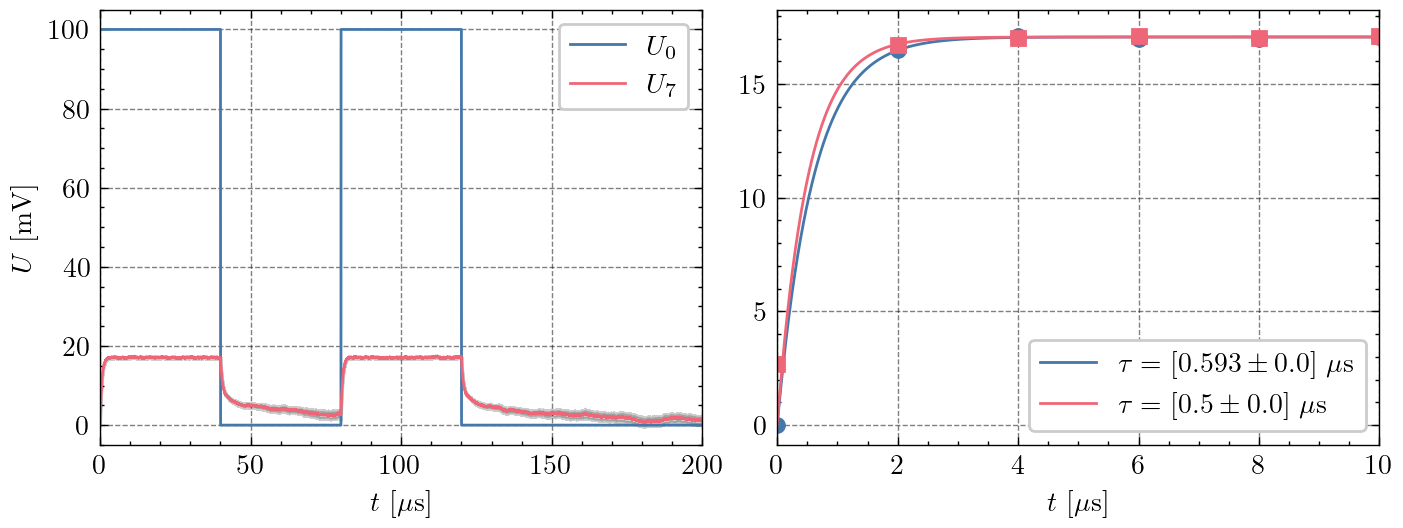

In [ ]:
steps_between   = 40000
df              = data_two[steps_between].copy()
fuc             = exp_saturation

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000

y   = df['Current'].values*1000
y_e = df['Error'].values*1000
y1  = y[:steps_per_step].copy()
y2  = y[steps_per_step+steps_between:2*steps_per_step+steps_between].copy()
# y1  -= y1[0]
# y2  -= y2[0]

ax.plot(t_vals, x, label='$U_0$')
ax.plot(t_vals, y, label='$U_7$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.set_ylabel('$U$ [mV]')
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
p,c = curve_fit(fuc, t_vals[:len(y1)], y1, p0=[2,100])
print(p)
p1  = ax.plot(t_vals[:len(y1)],y1, 'o', markevery=2000, ms=5)
ax.plot(t_vals[:len(y1)],fuc(t_vals[:len(y1)],*p), color=p1[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')

p,c = curve_fit(fuc, t_vals[:len(y2)],y2, p0=[2,50])#, bounds=[(0,0,0),(200,np.inf,1)])
print(p)
p2  = ax.plot(t_vals[:len(y2)],y2, 's', markevery=2000, ms=5)
ax.plot(t_vals[:len(y2)],fuc(t_vals[:len(y2)],*p), color=p2[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(loc='lower right')
# ax.set_xscale('log')
ax.set_xlim(0,10)

# fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.svg", transparent=True)
# fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.pdf", transparent=False)

## Increasing Steps

In [130]:
steps_per_step  = 40000
cap             = 5e3
folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/increasing_steps/"
df              = pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") 
N_voltages      = len(df)
time_step       = 1e-10
t_vals          = np.arange(N_voltages)*1e-10*1e6

[22.65823247 58.07212674]
[ 3.27628609 17.8294665 ]
[ 7.41421575 43.06513887]
[ 2.98640029 23.38515884]
[ 6.25804016 45.95597669]
[4.97020421 1.42034047]
[ 26.6192968  -37.45821997]
[  4.15274332 -29.64337648]
[  2.49407201 -17.62077896]
[  4.37642488 -37.39508781]


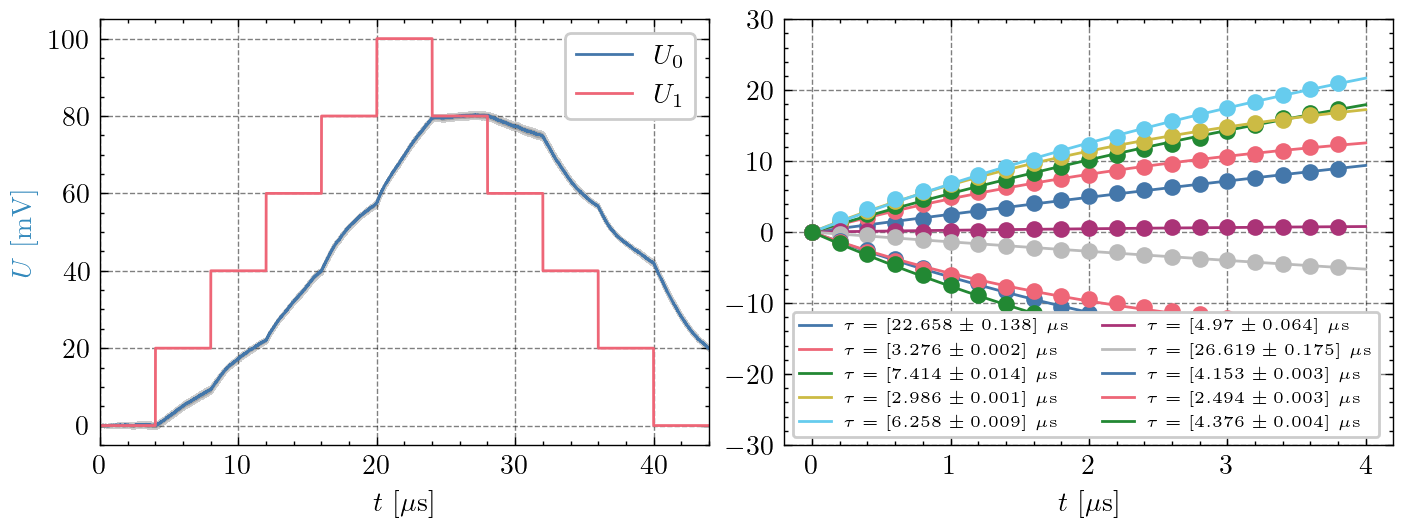

In [131]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000

ax.plot(t_vals, y, label='$U_0$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.plot(t_vals, x, label='$U_1$')
ax.set_ylabel('$U$ [mV]', color=nanonets_utils.blue_color)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
for i in range(1,11):
    y1  =   y[i*steps_per_step:(i+1)*steps_per_step].copy()
    y1  -=  y1[0]
    p,c = curve_fit(exp_saturation, t_vals[:len(y1)], y1)
    print(p)
    p1  = ax.plot(t_vals[:len(y1)], y1, 'o', markevery=2000, ms=5)
    ax.plot(t_vals[:len(y1)], exp_saturation(t_vals[:len(y1)], *p), color=p1[0].get_color(),
            label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(fontsize='xx-small', ncol=2)
ax.set_ylim(-30,30)

fig.savefig(f"../plots/increasing_steps.svg", transparent=True)
fig.savefig(f"../plots/increasing_steps.pdf", transparent=False)